In [1]:
import shap
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
original_df = pd.read_csv("../0. Data/classification_data.csv")
original_df = original_df.drop(columns=["Recycle ratio (total return sludge flow/total influent flow).1"])
original_df.columns.to_list()

['Sample',
 'Position',
 'Country',
 'City',
 'Plant',
 'Date',
 'Volume of aeration tanks (m3)',
 'Actual Inf rate (m3/d)',
 '℃ Temp.Max.SamplingDate',
 '℃ Temp.Avg.SamplingDate',
 '℃ Temp.Min.SamplingDate',
 '℃ Dew.Max.SamplingDate',
 '℃ Dew.Avg.SamplingDate',
 '℃ Dew.Min.SamplingDate',
 '℃ Humidity.Max.SamplingDate',
 '℃ Humidity.Min.SamplingDate',
 '℃ Wind.Max.SamplingDate',
 '℃ Wind.Min.SamplingDate',
 '℃ Pressure.Max.SamplingDate',
 '℃ Pressure.Min.SamplingDate',
 '℃ Precipitation.SamplingDate',
 '℃ Temp.Max.WeekMean',
 '℃ Temp.Avg.WeekMean',
 '℃ Temp.Min.WeekMean',
 '℃ Dew.Max.WeekMean',
 '℃ Dew.Avg.WeekMean',
 '℃ Dew.Min.WeekMean',
 '℃ Humidity.Max.WeekMean',
 '℃ Humidity.Min.WeekMean',
 '℃ Wind.Max.WeekMean',
 '℃ Wind.Min.WeekMean',
 '℃ Pressure.Max.WeekMean',
 '℃ Pressure.Min.WeekMean',
 '℃ Precipitation.WeekMean',
 '℃ Temp.Max.WeekMax',
 '℃ Temp.Avg.WeekMax',
 '℃ Temp.Min.WeekMax',
 '℃ Dew.Max.WeekMax',
 '℃ Dew.Avg.WeekMax',
 '℃ Dew.Min.WeekMax',
 '℃ Humidity.Max.WeekMax',
 

In [3]:
as_list = [
    'NewcastleAS', 'VarbergAS', 'SFAS',
    'Beijing3AS', 'Beijing2AS', 'GuangzhouAS',
    'KnoxvilleASP1', 'KnoxvilleASP2', 'KnoxvilleASP3',
    'DurbanASP1', 'DurbanASP2', 'DurbanASP3', 'DurbanASP4',
    'LisbonAS', 'ChicagoAS',
    'NormanASP1', 'NormanASP2', 'NormanASP3'
]

filtered_df = original_df[original_df["Position"].isin(as_list)]
len(as_list)
print(original_df["Position"].unique(), filtered_df["Position"].unique())

['NewcastleAS' 'VarbergAS' 'VarbergINF' 'SFAS' 'SFINF' 'Bejing3INF'
 'Beijing3AS' 'Beijing2AS' 'Beijing2INF' 'GuangzhouINF' 'GuangzhouAS'
 'KnoxvilleINF' 'KnoxvilleASP1' 'KnoxvilleASP2' 'KnoxvilleASP3'
 'DurbanASP1' 'DurbanASP2' 'DurbanASP3' 'DurbanASP4' 'LisbonINF'
 'LisbonAS' 'ChicagoAS' 'NormanINF' 'NormanASP1' 'NormanASP2' 'NormanASP3'
 'NormanEFF'] ['NewcastleAS' 'VarbergAS' 'SFAS' 'Beijing3AS' 'Beijing2AS' 'GuangzhouAS'
 'KnoxvilleASP1' 'KnoxvilleASP2' 'KnoxvilleASP3' 'DurbanASP1' 'DurbanASP2'
 'DurbanASP3' 'DurbanASP4' 'LisbonAS' 'ChicagoAS' 'NormanASP1'
 'NormanASP2' 'NormanASP3']


In [4]:
X_svd_df = pd.read_csv("../0. Data/relative_abundance_table.csv", index_col=0)
X_svd_df.columns = [f"ASV_{i+1}" for i in range(3125)]
# SVD로 시작하는 컬럼만 ASV로 바꾸기
# uk_df.columns = [col.replace("SVD_", "ASV_") if col.startswith("SVD_") else col for col in uk_df.columns]

X_svd_df

,ASV_1,ASV_2,ASV_3,ASV_4,ASV_5,ASV_6,ASV_7,ASV_8,ASV_9,ASV_10,...,ASV_3116,ASV_3117,ASV_3118,ASV_3119,ASV_3120,ASV_3121,ASV_3122,ASV_3123,ASV_3124,ASV_3125
UK01A,0.000000,0.097762,0.046419,0.000000,0.022739,0.042871,0.099573,0.0,0.006662,0.004055,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UK02A,0.000000,0.071315,0.048201,0.000000,0.021742,0.032205,0.100390,0.0,0.005618,0.003688,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UK03A,0.000000,0.073343,0.048030,0.000000,0.020846,0.039139,0.088275,0.0,0.006509,0.004127,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UK04A,0.000000,0.067344,0.041381,0.000000,0.026551,0.028988,0.111961,0.0,0.006134,0.003403,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UK05A,0.000000,0.067793,0.033581,0.000000,0.026604,0.036691,0.119363,0.0,0.005800,0.005800,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GZ101,0.000000,0.000000,0.000000,0.001453,0.000000,0.000000,0.000000,0.0,0.000436,0.008719,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GZ102,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.001558,0.007414,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GZ103,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.001048,0.003370,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GZ104,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.003751,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:

filtered_df_indexed = filtered_df.set_index("Sample")

# X_svd_df와 병합
merged_df = filtered_df_indexed.join(X_svd_df, how="inner")

# 결과 확인
print(merged_df.shape)
merged_df


(813, 3215)


,Position,Country,City,Plant,Date,Volume of aeration tanks (m3),Actual Inf rate (m3/d),℃ Temp.Max.SamplingDate,℃ Temp.Avg.SamplingDate,℃ Temp.Min.SamplingDate,...,ASV_3116,ASV_3117,ASV_3118,ASV_3119,ASV_3120,ASV_3121,ASV_3122,ASV_3123,ASV_3124,ASV_3125
UK01A,NewcastleAS,United Kindom,Newcastle,UKTM1A,2015-01-28,3600.0,17254.0,6.67,3.33,0.56,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UK02A,NewcastleAS,United Kindom,Newcastle,UKTM1A,2015-02-04,3600.0,7007.0,5.56,3.33,0.56,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UK03A,NewcastleAS,United Kindom,Newcastle,UKTM1A,2015-02-11,3600.0,7197.0,5.56,4.44,2.78,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UK04A,NewcastleAS,United Kindom,Newcastle,UKTM1A,2015-02-18,3600.0,6126.0,11.67,10.00,8.89,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UK05A,NewcastleAS,United Kindom,Newcastle,UKTM1A,2015-02-25,3600.0,6898.0,10.56,7.78,5.56,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
N48C,NormanASP3,United States,Norman,USNO2,2015-12-23,9751.2,31922.0,20.56,9.44,-1.67,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
N49C,NormanASP3,United States,Norman,USNO2,2015-12-30,9751.2,45538.0,0.56,-2.22,-5.56,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
N50C,NormanASP3,United States,Norman,USNO2,2016-01-06,9751.2,39274.0,11.67,8.33,4.44,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
N51C,NormanASP3,United States,Norman,USNO2,2016-01-13,9751.2,34284.0,14.44,5.56,-3.33,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [180]:
svd_cols = [col for col in merged_df.columns if col.startswith('ASV_')]

# 2. feature_columns 리스트 정의
feature_columns = [
 'Actual Inf rate (m3/d)',
 '℃ Temp.Max.SamplingDate',
 '℃ Temp.Avg.SamplingDate',
 '℃ Temp.Min.SamplingDate',
 '℃ Dew.Max.SamplingDate',
 '℃ Dew.Avg.SamplingDate',
 '℃ Dew.Min.SamplingDate',
 '℃ Humidity.Max.SamplingDate',
 '℃ Humidity.Min.SamplingDate',
 '℃ Wind.Max.SamplingDate',
 '℃ Wind.Min.SamplingDate',
 '℃ Pressure.Max.SamplingDate',
 '℃ Pressure.Min.SamplingDate',
 '℃ Temp.Max.WeekMean',
 '℃ Temp.Avg.WeekMean',
 '℃ Temp.Min.WeekMean',
 '℃ Dew.Max.WeekMean',
 '℃ Dew.Avg.WeekMean',
 '℃ Dew.Min.WeekMean',
 '℃ Humidity.Max.WeekMean',
 '℃ Humidity.Min.WeekMean',
 '℃ Wind.Max.WeekMean',
 '℃ Wind.Min.WeekMean',
 '℃ Pressure.Max.WeekMean',
 '℃ Pressure.Min.WeekMean',
 '℃ Temp.Max.WeekMax',
 '℃ Temp.Avg.WeekMax',
 '℃ Temp.Min.WeekMax',
 '℃ Dew.Max.WeekMax',
 '℃ Dew.Avg.WeekMax',
 '℃ Dew.Min.WeekMax',
 '℃ Humidity.Max.WeekMax',
 '℃ Humidity.Min.WeekMax',
 '℃ Wind.Max.WeekMax',
 '℃ Wind.Min.WeekMax',
 '℃ Pressure.Max.WeekMax',
 '℃ Pressure.Min.WeekMax',
 'COD (mg/l) In',
 'COD (mg/l) Out',
 'NH3 (mg/L) In',
 'NH3 (mg/L) Out',
 'Total Nitrogen (mg/L) In',
 'Total Nitrogen (mg/L) Out',
 'Total Phosphorus (mg/L) In',
 'Total Phosphorus (mg/L) Out',
 'pH AS',
 'DO (mg/L) AS',
 'Temp (oC) AS',
 'MLSS (mg/l) AS',
 'MLVSS (mg/l) AS',
 'SVI (ml/g) AS',
 'SRT (days)',
 'Calcium (mg/L)',
 'Magnesium (mg/L)',
 'Potassium (mg/L)',
 'Iron (mg/L)',
 'Manganese (mg/L)',
 'Lead (mg/L)',
 'Copper (mg/L)',
 'Arsenic (mg/L)',
 'Sulphur (mg/L)',
 'Sillicon (mg/L)',
 'Q* (%)',
 'COD Removal Rate (mg/L/h)',
 'COD Removal Efficiency (%)',
 'COD_influent_rate (g/l/h)',
 'efficiency',]

# feature_columns=[]
# 3. 두 컬럼 리스트 합치기
selected_columns = feature_columns + svd_cols

# 4. 해당 컬럼만 가져오기
selected_df = merged_df[selected_columns]
selected_df

,Actual Inf rate (m3/d),℃ Temp.Max.SamplingDate,℃ Temp.Avg.SamplingDate,℃ Temp.Min.SamplingDate,℃ Dew.Max.SamplingDate,℃ Dew.Avg.SamplingDate,℃ Dew.Min.SamplingDate,℃ Humidity.Max.SamplingDate,℃ Humidity.Min.SamplingDate,℃ Wind.Max.SamplingDate,...,ASV_3116,ASV_3117,ASV_3118,ASV_3119,ASV_3120,ASV_3121,ASV_3122,ASV_3123,ASV_3124,ASV_3125
UK01A,17254.0,6.67,3.33,0.56,36,32,30,93,70,25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UK02A,7007.0,5.56,3.33,0.56,34,31,27,81,65,13,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UK03A,7197.0,5.56,4.44,2.78,37,35,34,87,76,9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UK04A,6126.0,11.67,10.00,8.89,46,45,45,87,76,26,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UK05A,6898.0,10.56,7.78,5.56,50,45,41,94,82,20,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
N48C,31922.0,20.56,9.44,-1.67,49,38,28,100,28,32,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
N49C,45538.0,0.56,-2.22,-5.56,29,26,21,100,85,13,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
N50C,39274.0,11.67,8.33,4.44,47,43,38,100,71,23,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
N51C,34284.0,14.44,5.56,-3.33,29,24,17,92,21,14,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [181]:
# 환경 변수 + 'ASV_258'만 남기기
uk_df = selected_df[selected_df.index.str.startswith('UK')]
uk_df
# cols_to_keep = [col for col in uk_df.columns if not col.startswith('ASV_') or col == 'ASV_285']
# filtered_df = uk_df[cols_to_keep]
# filtered_df

,Actual Inf rate (m3/d),℃ Temp.Max.SamplingDate,℃ Temp.Avg.SamplingDate,℃ Temp.Min.SamplingDate,℃ Dew.Max.SamplingDate,℃ Dew.Avg.SamplingDate,℃ Dew.Min.SamplingDate,℃ Humidity.Max.SamplingDate,℃ Humidity.Min.SamplingDate,℃ Wind.Max.SamplingDate,...,ASV_3116,ASV_3117,ASV_3118,ASV_3119,ASV_3120,ASV_3121,ASV_3122,ASV_3123,ASV_3124,ASV_3125
UK01A,17254.0,6.67,3.33,0.56,36,32,30,93,70,25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UK02A,7007.0,5.56,3.33,0.56,34,31,27,81,65,13,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UK03A,7197.0,5.56,4.44,2.78,37,35,34,87,76,9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UK04A,6126.0,11.67,10.00,8.89,46,45,45,87,76,26,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UK05A,6898.0,10.56,7.78,5.56,50,45,41,94,82,20,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UK06A,6049.0,8.89,5.56,2.78,36,34,30,81,50,18,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UK08A,4752.0,11.67,5.56,0.00,39,36,30,100,44,9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UK09A,6982.0,8.89,4.44,0.56,36,32,28,87,46,24,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UK10A,6860.0,7.78,5.56,2.78,39,37,34,87,71,18,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UK11A,6159.0,15.00,9.44,3.89,45,42,36,93,55,14,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [182]:
uk_df = uk_df.sort_index()  # 혹은 날짜 컬럼 기준으로 정렬
uk_df = uk_df.loc[:, (uk_df != 0).any(axis=0)]
uk_df

,Actual Inf rate (m3/d),℃ Temp.Max.SamplingDate,℃ Temp.Avg.SamplingDate,℃ Temp.Min.SamplingDate,℃ Dew.Max.SamplingDate,℃ Dew.Avg.SamplingDate,℃ Dew.Min.SamplingDate,℃ Humidity.Max.SamplingDate,℃ Humidity.Min.SamplingDate,℃ Wind.Max.SamplingDate,...,ASV_2849,ASV_2850,ASV_2851,ASV_2852,ASV_2853,ASV_2854,ASV_2855,ASV_2856,ASV_2857,ASV_2858
UK01A,17254.0,6.67,3.33,0.56,36,32,30,93,70,25,...,0.000000,0.000000,0.000000,0.000145,0.000724,0.000000,0.000000,0.000000,0.000000,0.000000
UK02A,7007.0,5.56,3.33,0.56,34,31,27,81,65,13,...,0.000343,0.000343,0.000129,0.000129,0.000000,0.000214,0.000000,0.000000,0.000000,0.000000
UK03A,7197.0,5.56,4.44,2.78,37,35,34,87,76,9,...,0.000128,0.000425,0.000000,0.000085,0.000000,0.000766,0.000000,0.000000,0.000000,0.000000
UK04A,6126.0,11.67,10.00,8.89,46,45,45,87,76,26,...,0.000000,0.000588,0.000294,0.000252,0.000000,0.001470,0.000000,0.000126,0.000000,0.000000
UK05A,6898.0,10.56,7.78,5.56,50,45,41,94,82,20,...,0.000294,0.000000,0.000294,0.000420,0.000000,0.000294,0.000000,0.000000,0.000000,0.000000
UK06A,6049.0,8.89,5.56,2.78,36,34,30,81,50,18,...,0.000084,0.000294,0.000252,0.000504,0.000000,0.000000,0.000000,0.000210,0.000000,0.000000
UK08A,4752.0,11.67,5.56,0.00,39,36,30,100,44,9,...,0.000253,0.000000,0.000168,0.000421,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
UK09A,6982.0,8.89,4.44,0.56,36,32,28,87,46,24,...,0.000296,0.000507,0.000296,0.001013,0.000000,0.000000,0.000000,0.000211,0.000000,0.000000
UK10A,6860.0,7.78,5.56,2.78,39,37,34,87,71,18,...,0.000000,0.000581,0.000000,0.000166,0.000000,0.000000,0.000000,0.000291,0.000000,0.000000
UK11A,6159.0,15.00,9.44,3.89,45,42,36,93,55,14,...,0.000166,0.000456,0.000124,0.000497,0.000000,0.000331,0.000000,0.000456,0.000000,0.000000


In [37]:
# ASV 컬럼만 추출 (ASV_*** 형식)
asv_columns = [col for col in uk_df.columns if col.startswith('ASV_')]

# 상관계수 행렬 계산
corr_matrix = uk_df[asv_columns].corr(method='pearson')

# ASV_285과 다른 ASV들의 상관계수 정렬
asv_285_corr = corr_matrix['ASV_285'].drop('ASV_285').sort_values(ascending=False, key=lambda x: abs(x))

# 상위 10개 ASV 출력
print("ASV_285와 가장 유사한 ASV들 (절댓값 기준 상위 10):")
print(asv_285_corr.head(10))


ASV_285와 가장 유사한 ASV들 (절댓값 기준 상위 10):
ASV_214    -0.826695
ASV_663     0.819297
ASV_121     0.806999
ASV_727    -0.801807
ASV_190    -0.769209
ASV_951    -0.768690
ASV_521    -0.768407
ASV_296     0.767153
ASV_851    -0.767089
ASV_1034    0.766240
Name: ASV_285, dtype: float64


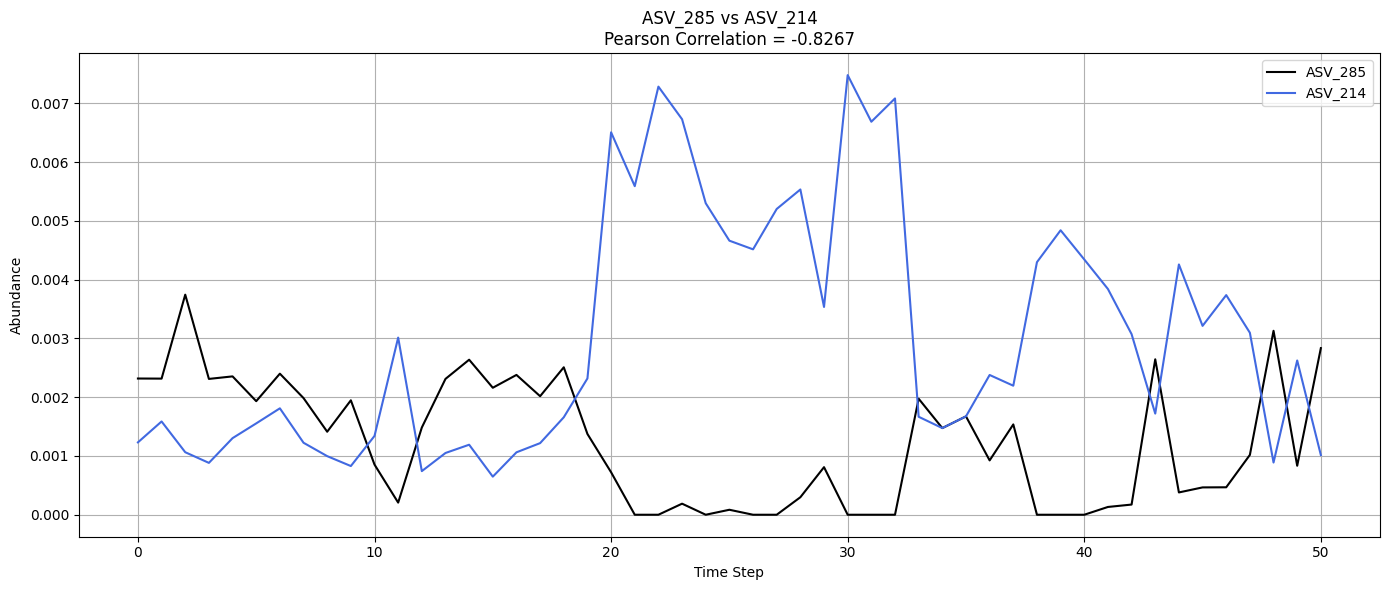

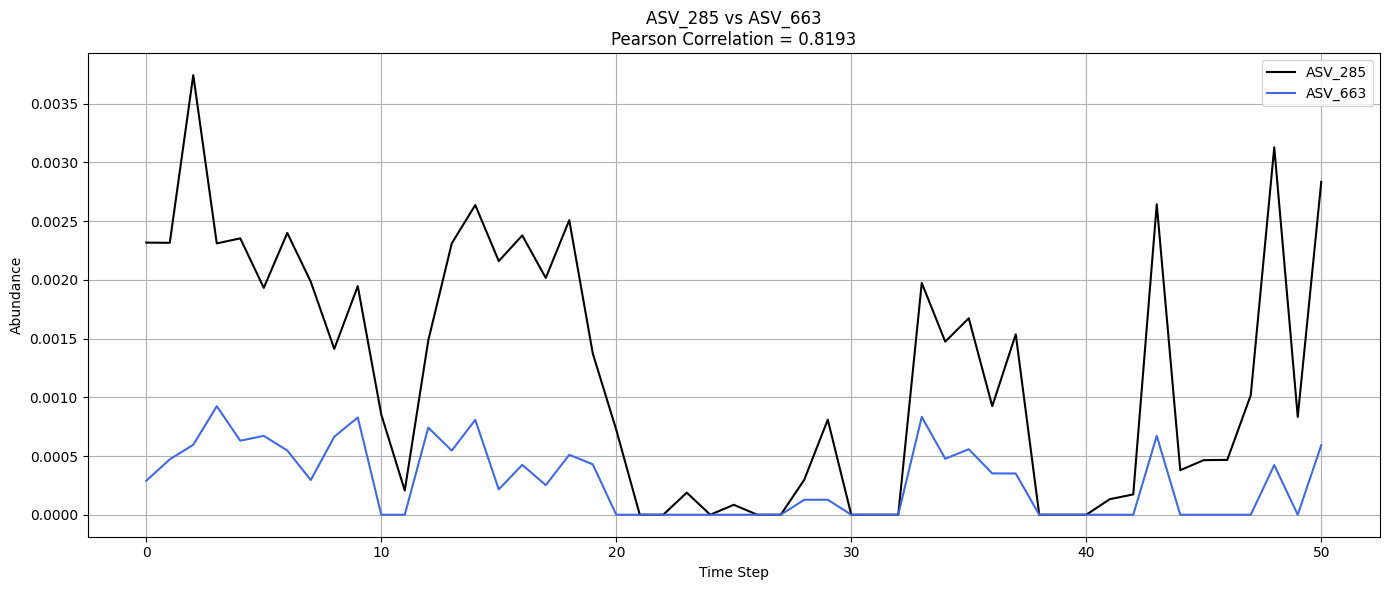

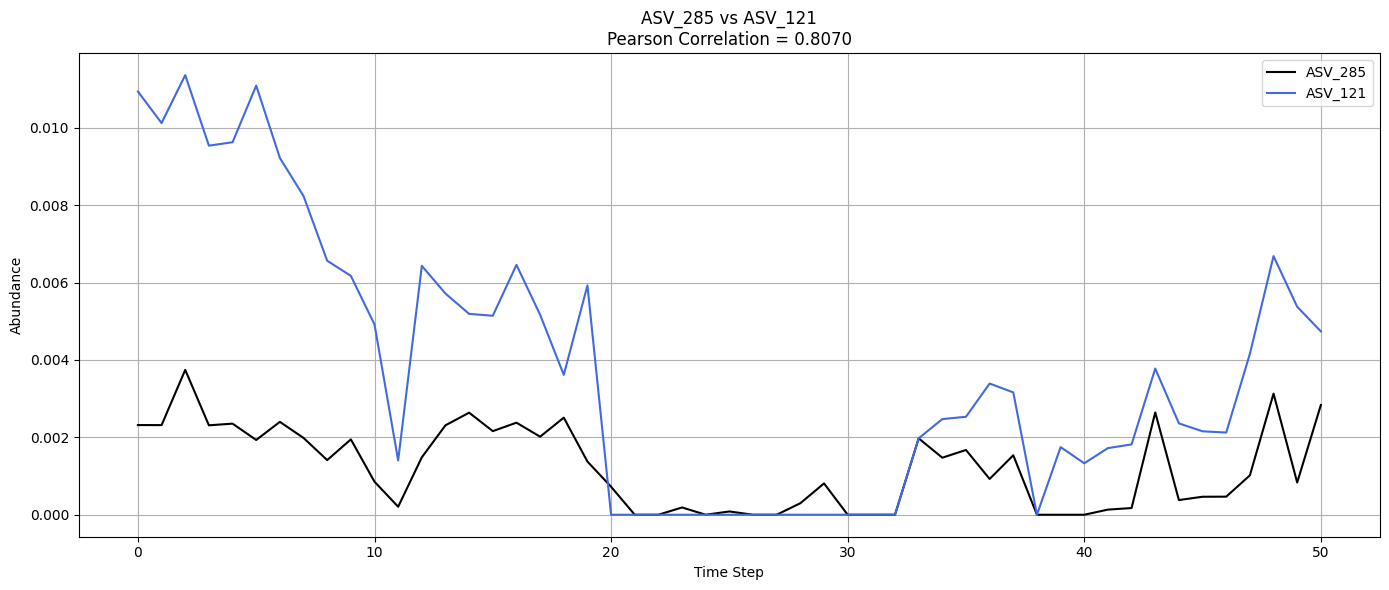

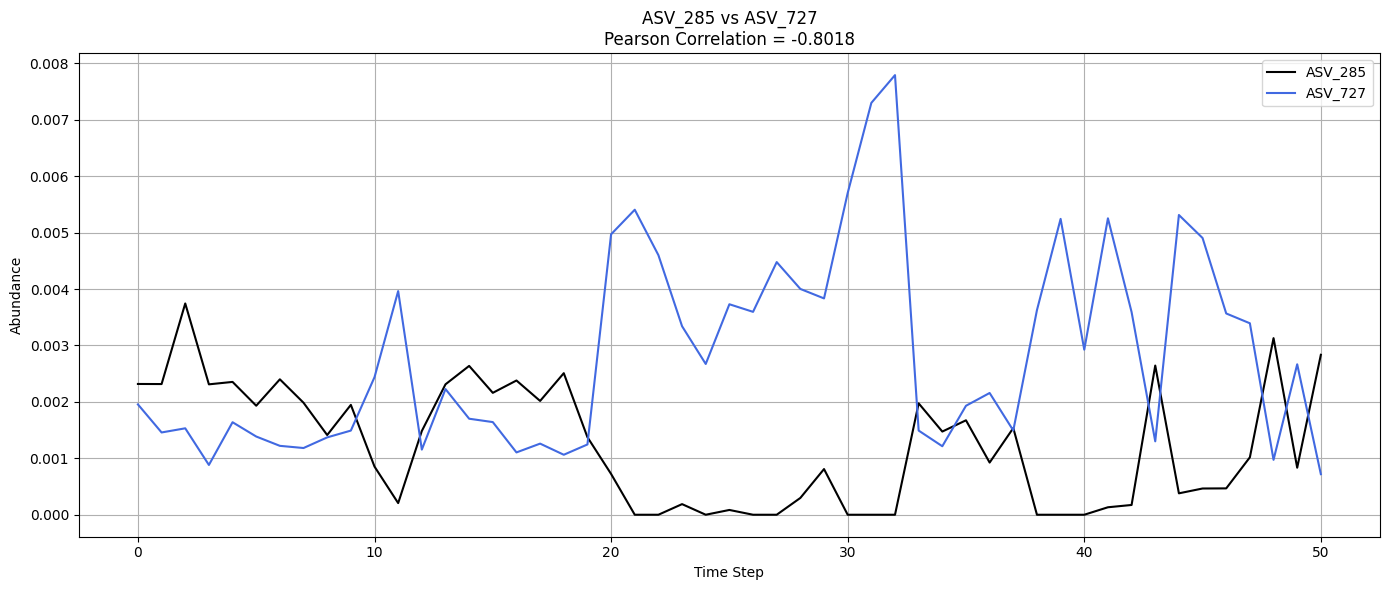

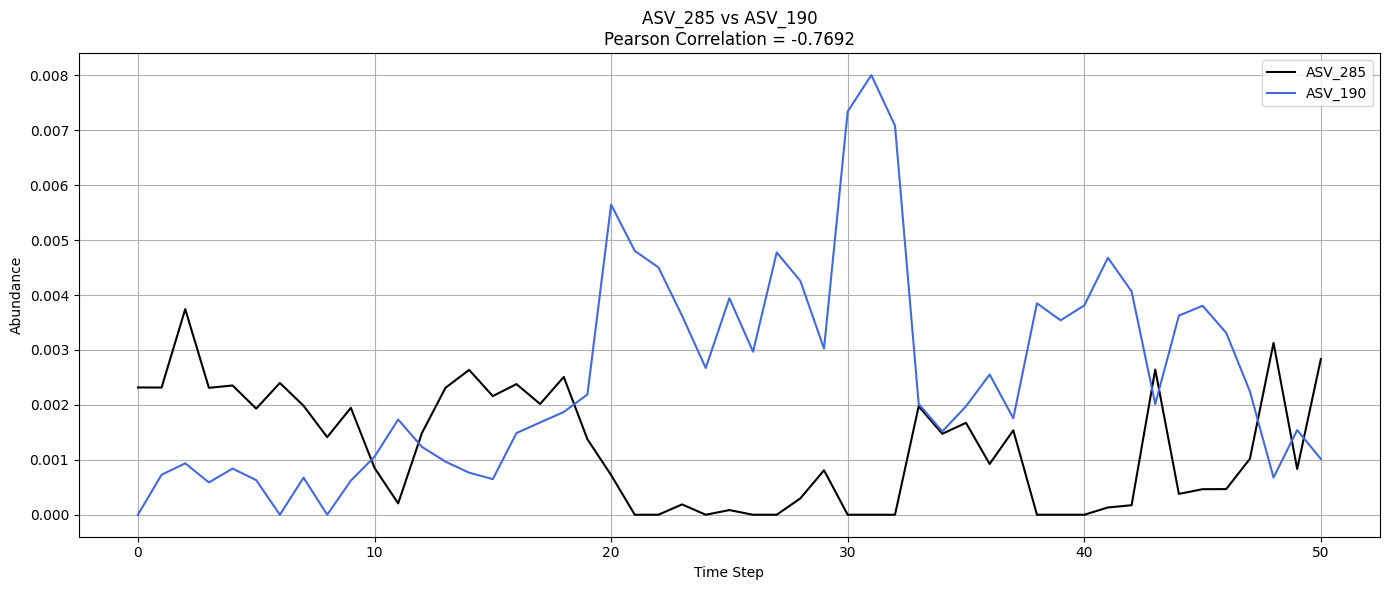

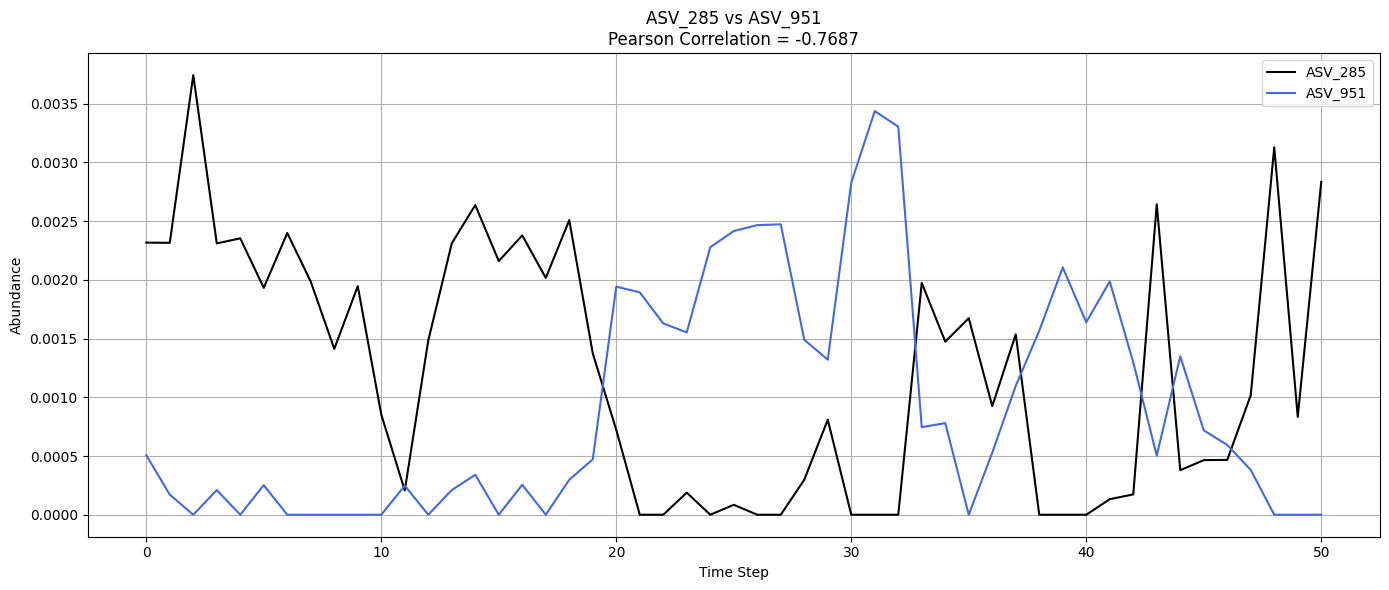

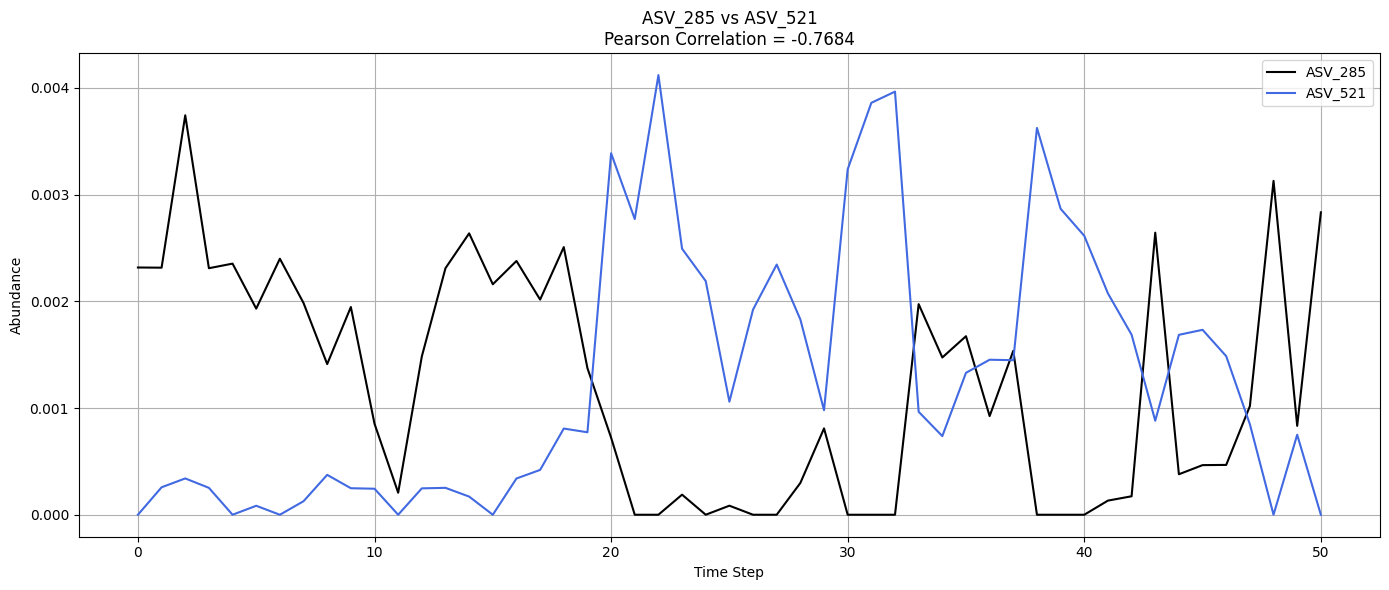

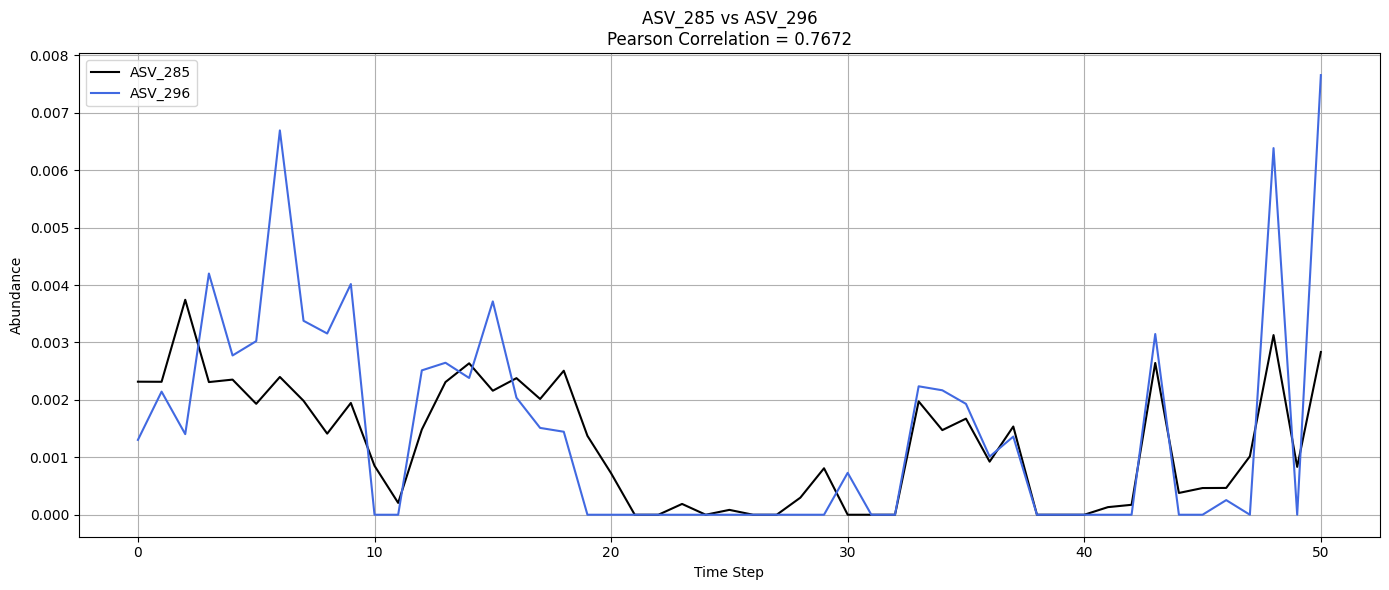

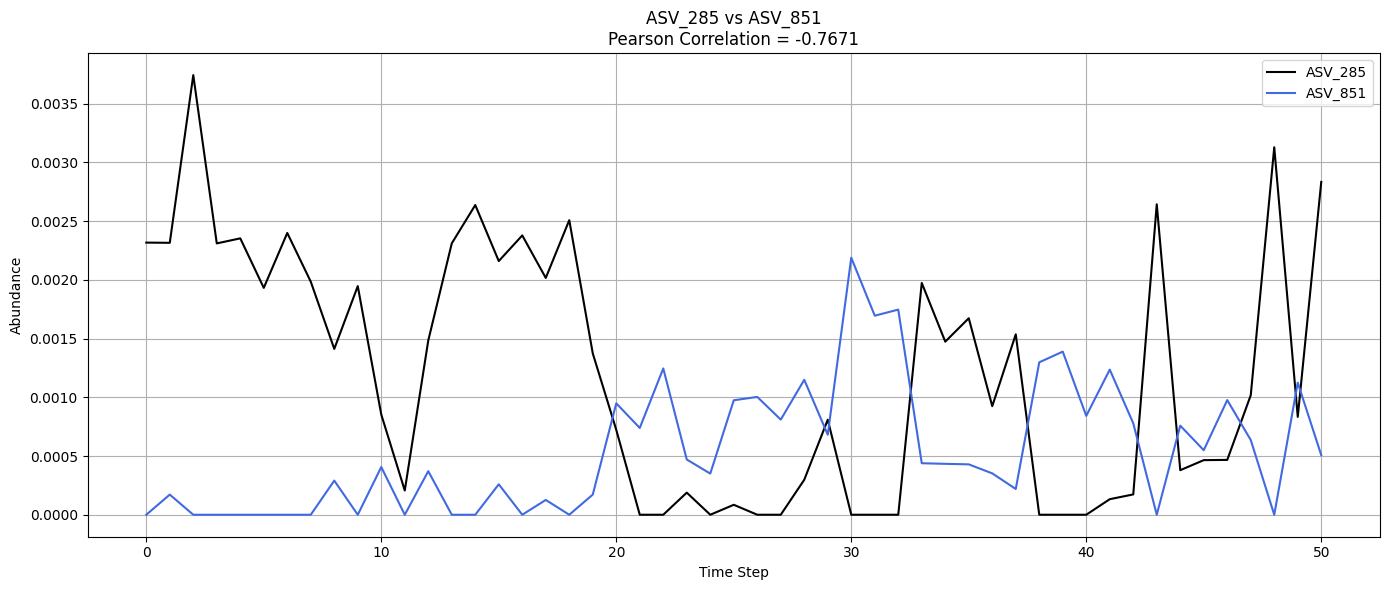

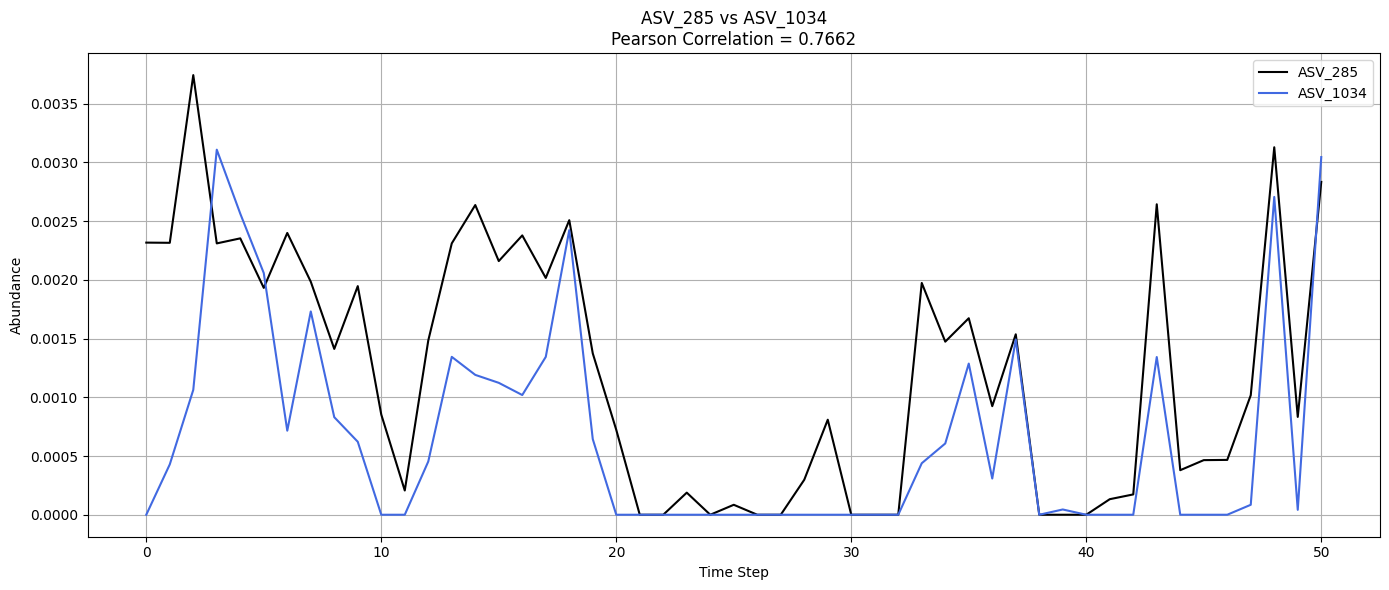

In [92]:
# 기준 시계열
Y_actual = uk_df['ASV_285']
top_asvs = asv_285_corr.head(10)  # 상위 유사 ASV와 상관계수

# 반복: 시각화 (상관계수 포함 제목)
for asv, corr in top_asvs.items():
    # break
    Y_compare = uk_df[asv]

    plt.figure(figsize=(14, 6))
    plt.plot(Y_actual.values, label='ASV_285', color='black', linestyle='-')
    plt.plot(Y_compare.values, label=asv, color='royalblue')
    # plt.axvline(len(Y_actual) * 0.8, color='red', linestyle='--', label='Train/Test Split')
    plt.title(f'ASV_285 vs {asv}\nPearson Correlation = {corr:.4f}')
    plt.xlabel('Time Step')
    plt.ylabel('Abundance')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [38]:
ESV_lookup =pd.read_table("../0. Data/merged.taxonomy.txt")
ESV_lookup

,ESVs,Kingdom,Phylum,Order,Class,Family,Genus,Species,Leastone2
0,ESV34208,Bacteria,Lentisphaerae,Lentisphaeria,Victivallales,GWF2-44-16,uncultured bacterium,uncultured bacterium,D_4__GWF2-44-16
1,ESV1,Bacteria,Bacteroidetes,Bacteroidia,Chitinophagales,Saprospiraceae,uncultured,NaN,D_4__Saprospiraceae
2,ESV10,Bacteria,Firmicutes,Bacilli,Lactobacillales,Carnobacteriaceae,Trichococcus,NaN,D_5__Trichococcus
3,ESV100,Bacteria,Proteobacteria,Gammaproteobacteria,Betaproteobacteriales,Burkholderiaceae,Rhodoferax,NaN,D_5__Rhodoferax
4,ESV1000,Bacteria,Acidobacteria,Blastocatellia (Subgroup 4),24-Nov,uncultured bacterium,uncultured bacterium,uncultured bacterium,D_3__11-24
...,...,...,...,...,...,...,...,...,...
37854,ESV9995,Bacteria,Chloroflexi,Anaerolineae,Anaerolineales,Anaerolineaceae,uncultured,NaN,D_4__Anaerolineaceae
37855,ESV9996,Bacteria,Bacteroidetes,Bacteroidia,Sphingobacteriales,Lentimicrobiaceae,NaN,NaN,D_4__Lentimicrobiaceae
37856,ESV9997,Bacteria,BRC1,uncultured bacterium,uncultured bacterium,uncultured bacterium,uncultured bacterium,uncultured bacterium,D_1__BRC1
37857,ESV9998,Bacteria,Proteobacteria,Deltaproteobacteria,Oligoflexales,Oligoflexaceae,uncultured,uncultured bacterium,D_4__Oligoflexaceae


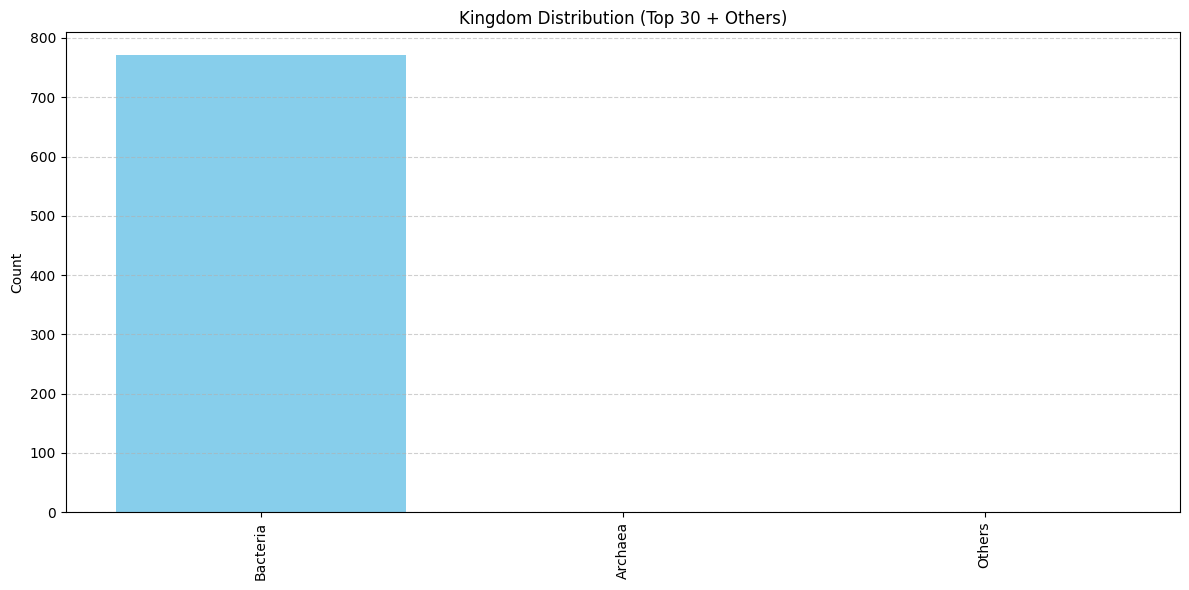

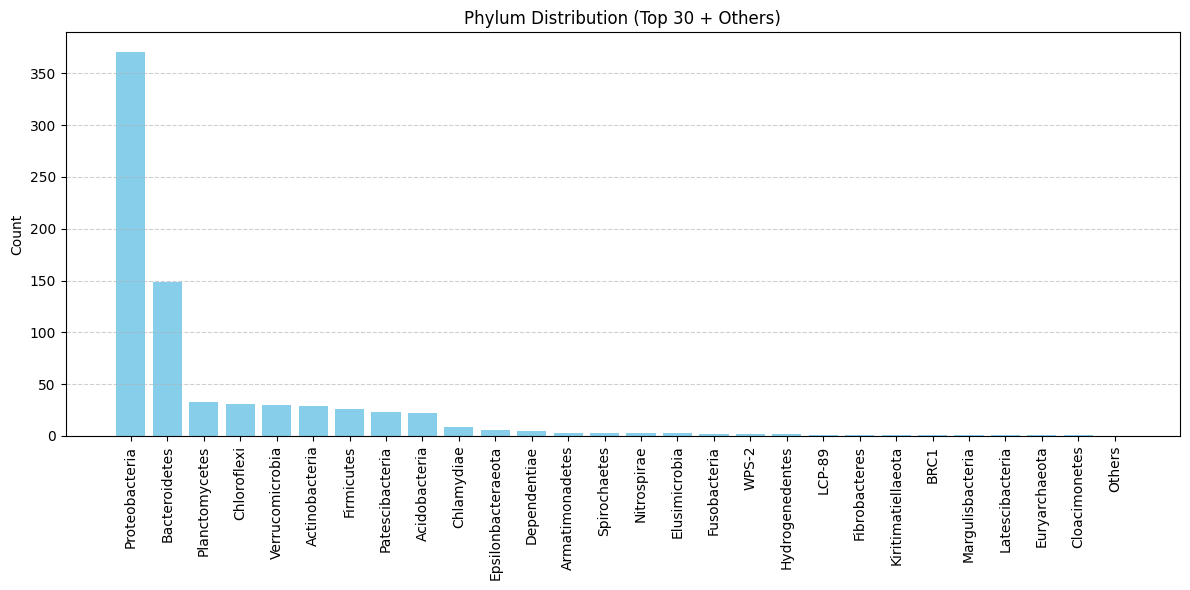

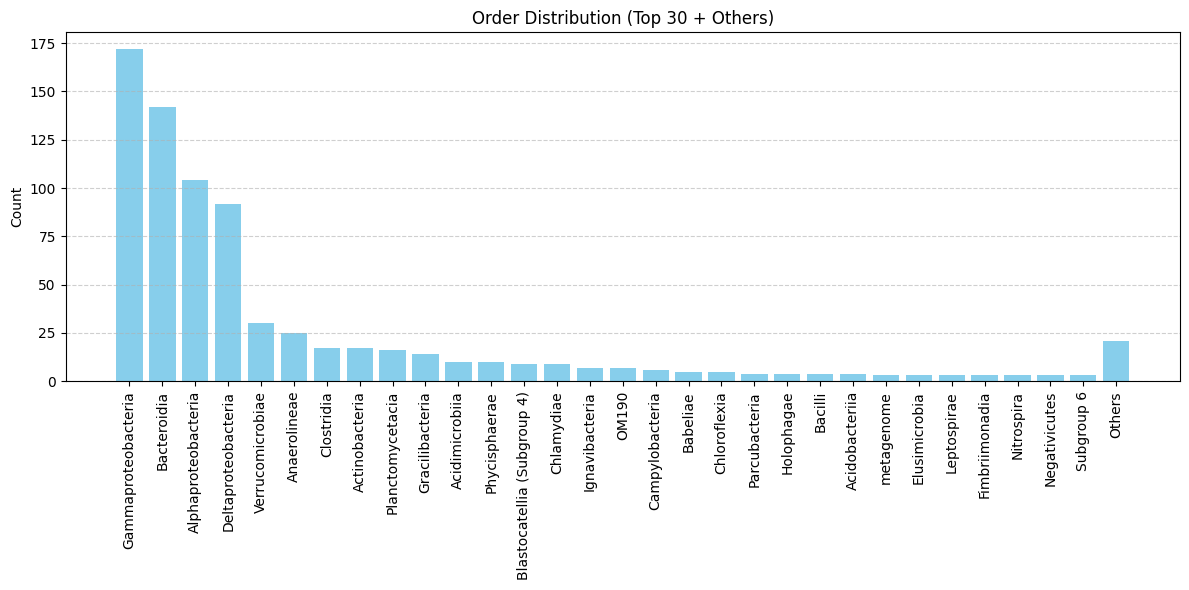

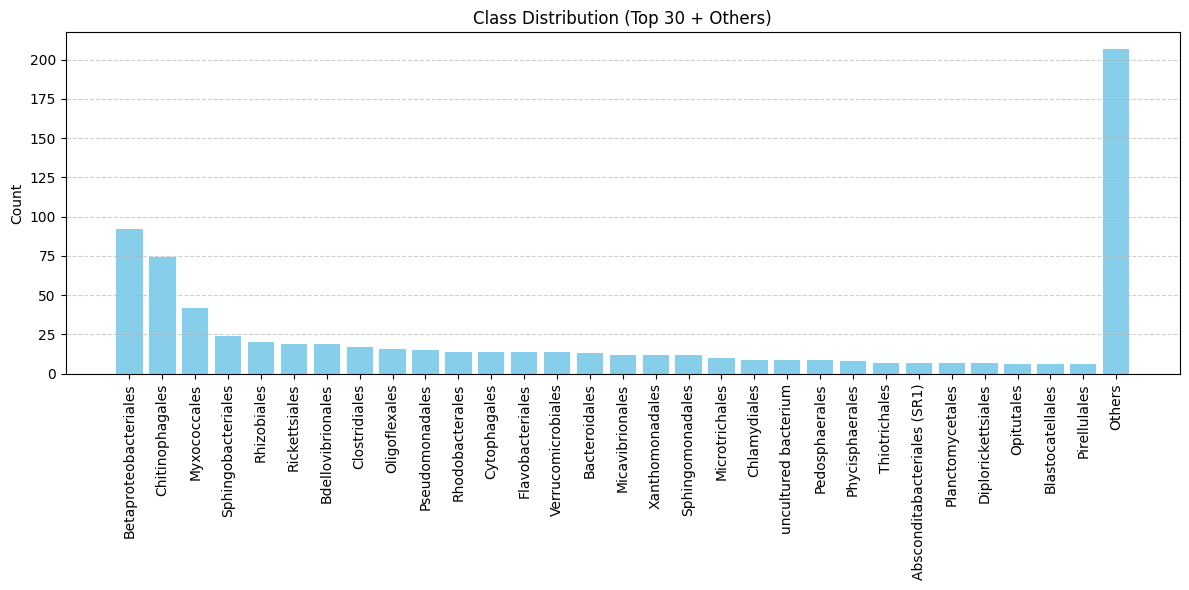

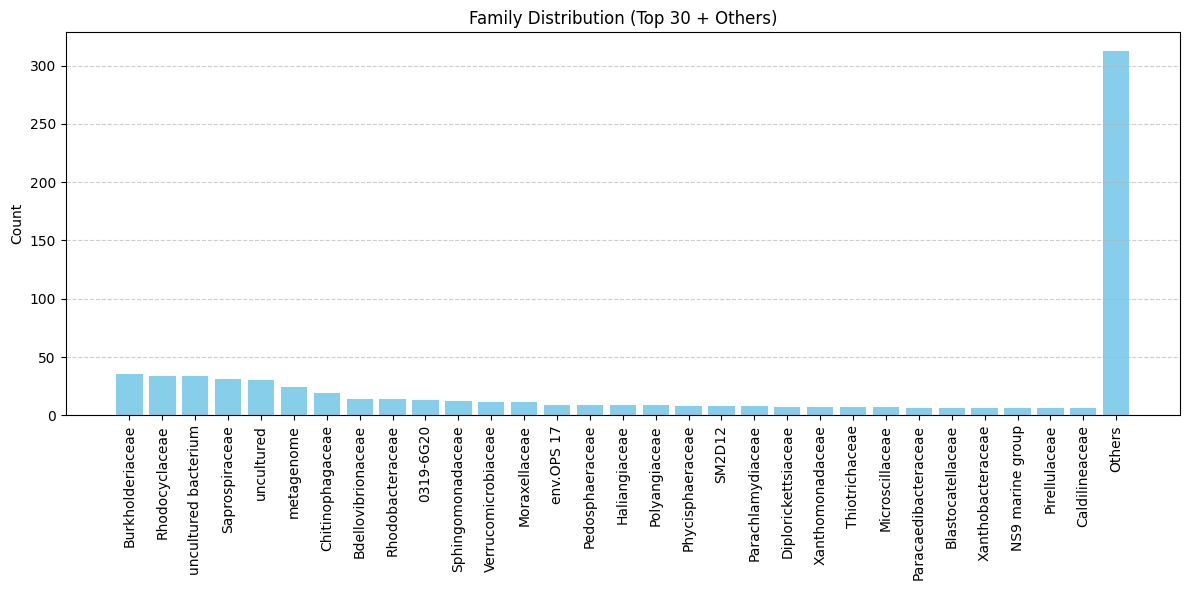

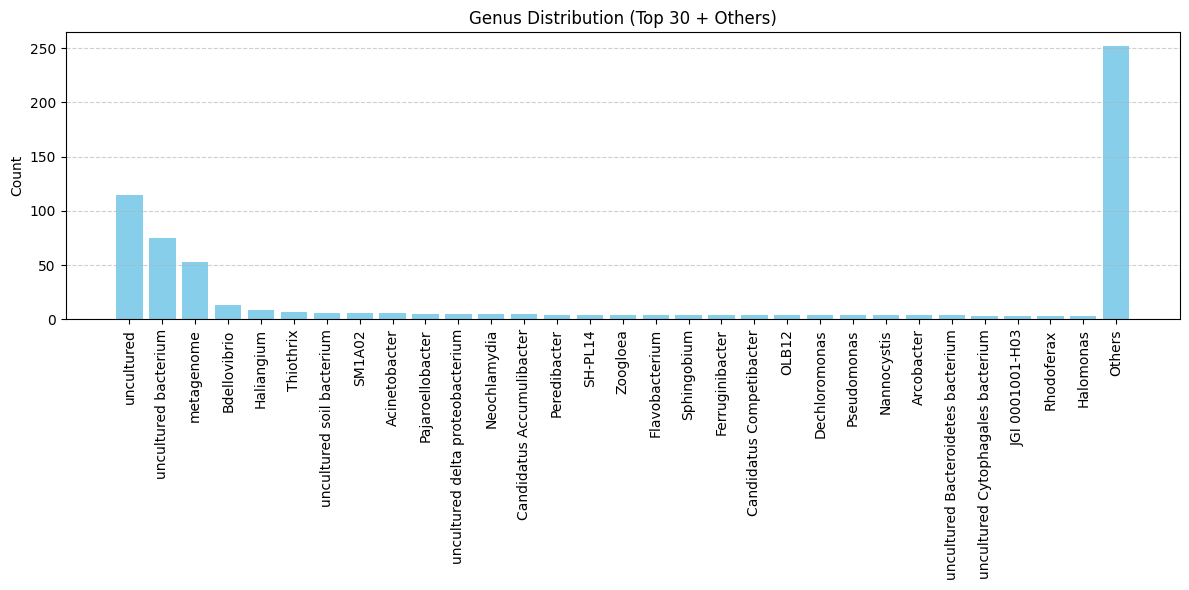

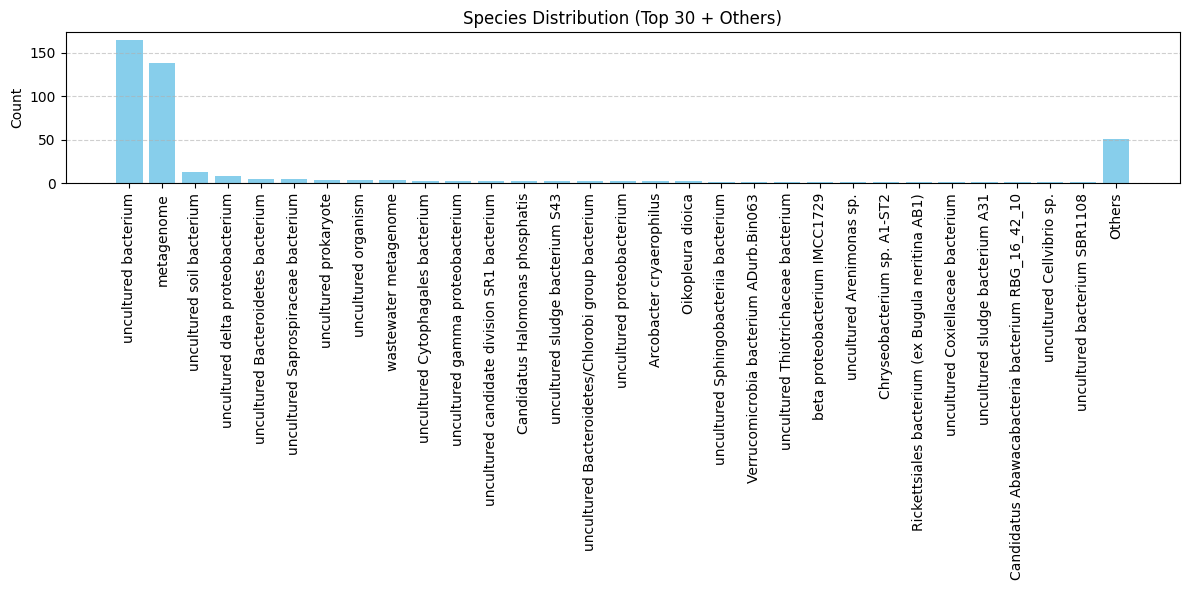

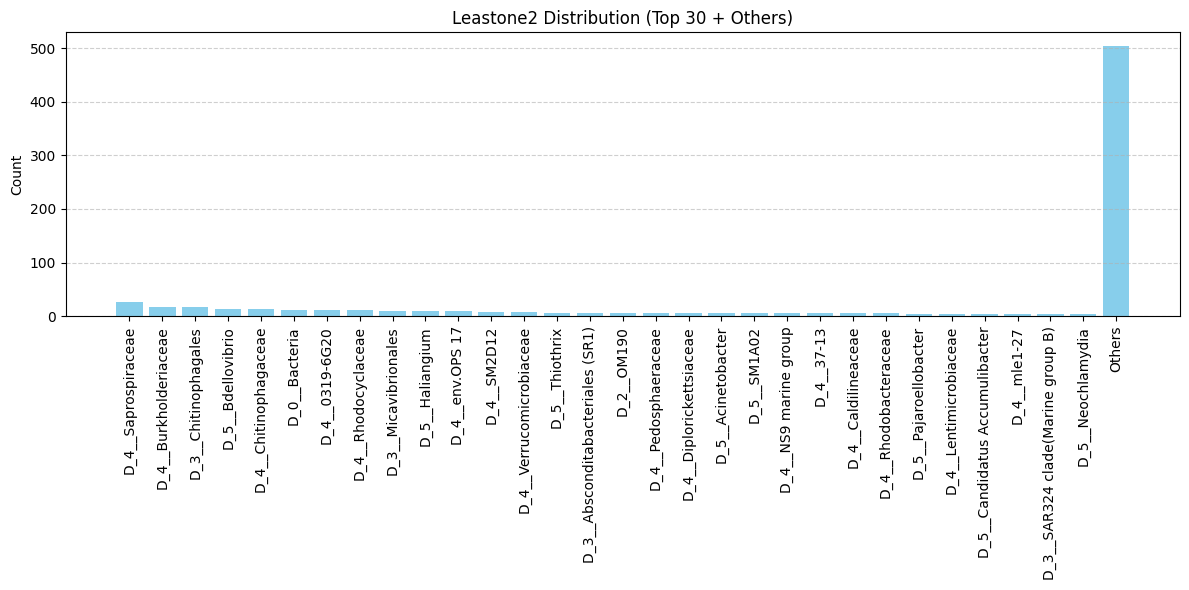

In [46]:
import matplotlib.pyplot as plt

# 현재 존재하는 ASV 컬럼들만 선택
asv_columns = [col for col in uk_df.columns if col.startswith('ASV_')]
esv_names = [asv.replace('ASV_', 'ESV') for asv in asv_columns]
matched_lookup = ESV_lookup[ESV_lookup['ESVs'].isin(esv_names)].copy()

# 계층별 바차트 함수 정의
def plot_bar_by_taxa(df, level, top_n=30):
    counts = df[level].value_counts()
    top_counts = counts.head(top_n)
    others = counts.iloc[top_n:].sum()

    labels = top_counts.index.tolist() + ['Others']
    values = top_counts.tolist() + [others]

    plt.figure(figsize=(12, 6))
    plt.bar(labels, values, color='skyblue')
    plt.xticks(rotation=90)
    plt.ylabel('Count')
    plt.title(f'{level} Distribution (Top {top_n} + Others)')
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


# 5. 주요 계층별 파이차트 그리기
for level in ['Kingdom', 'Phylum', 'Order', 'Class','Family', 'Genus', 'Species', 'Leastone2']:
    plot_bar_by_taxa(matched_lookup, level)


In [47]:
# 1. 유사한 ASV 10개 + ASV_285 포함
top_asvs_with_285 = ['ASV_285'] + asv_285_corr.head(10).index.tolist()

# 2. ASV → ESV 이름 변환
top_esvs = [asv.replace('ASV_', 'ESV') for asv in top_asvs_with_285]

# 3. 상관계수 DataFrame 만들기
asv_corr_df = asv_285_corr.head(10).reset_index()
asv_corr_df.columns = ['ASV', 'Correlation']
asv_corr_df = pd.concat([
    pd.DataFrame([{'ASV': 'ASV_285', 'Correlation': 1.0}]),
    asv_corr_df
], ignore_index=True)

# 4. ASV → ESV 변환 컬럼 추가
asv_corr_df['ESVs'] = asv_corr_df['ASV'].str.replace('ASV_', 'ESV')

# 5. ESV_lookup과 매칭하여 taxonomy 정보 결합
merged_taxonomy = pd.merge(asv_corr_df, ESV_lookup, on='ESVs', how='left')

print(merged_taxonomy)


         ASV  Correlation     ESVs   Kingdom          Phylum  \
0    ASV_285     1.000000   ESV285  Bacteria   Bacteroidetes   
1    ASV_214    -0.826695   ESV214  Bacteria  Proteobacteria   
2    ASV_663     0.819297   ESV663  Bacteria  Proteobacteria   
3    ASV_121     0.806999   ESV121  Bacteria  Proteobacteria   
4    ASV_727    -0.801807   ESV727  Bacteria  Proteobacteria   
5    ASV_190    -0.769209   ESV190  Bacteria  Proteobacteria   
6    ASV_951    -0.768690   ESV951  Bacteria   Bacteroidetes   
7    ASV_521    -0.768407   ESV521  Bacteria  Proteobacteria   
8    ASV_296     0.767153   ESV296  Bacteria   Bacteroidetes   
9    ASV_851    -0.767089   ESV851  Bacteria  Proteobacteria   
10  ASV_1034     0.766240  ESV1034  Bacteria  Proteobacteria   

                  Order                  Class              Family  \
0           Bacteroidia       Flavobacteriales    NS9 marine group   
1   Alphaproteobacteria          Rickettsiales      Rickettsiaceae   
2   Deltaproteobacter

In [ ]:
# 대상 컬럼: ASV_285 vs 나머지 모든 ASV
diff_df = uk_df.diff()
asv_columns = [col for col in diff_df.columns if col.startswith('ASV_') and col != 'ASV_285']



# 타겟 시리즈 (현재 시점)
y = diff_df['ASV_285']

# 결과 저장
lagged_correlations = {}

# 설정할 시차 범위 (예: t-1 ~ t-3까지)
for lag in [1, 2, 3]:
    corr_at_lag = {}
    for asv in asv_columns:
        x_lagged = uk_df[asv].shift(lag)  # X를 lag만큼 이동
        valid = y.notna() & x_lagged.notna()  # 유효한 데이터 구간만 비교
        corr = y[valid].corr(x_lagged[valid])
        corr_at_lag[asv] = corr
    # 저장
    lagged_correlations[f'lag_{lag}'] = pd.Series(corr_at_lag).sort_values(key=lambda x: abs(x), ascending=False)

# 예시 출력: lag=1일 때 상위 10개
print("ASV_285와 t-1 상관관계가 가장 높은 ASV들:")
print(lagged_correlations['lag_1'].head(10))


TypeError: unsupported operand type(s) for -: 'str' and 'str'

UK01A    0.000000
UK02A    0.000000
UK03A    0.000000
UK04A    0.000000
UK05A    0.000000
UK06A    0.000000
UK08A    0.000000
UK09A    0.000000
UK10A    0.000000
UK11A    0.000083
UK12A    0.000122
UK13A    0.000124
UK14A    0.000000
UK15A    0.000084
UK16A    0.000000
UK17A    0.000000
UK18A    0.000000
UK19A    0.000168
UK20A    0.000000
UK21A    0.000301
UK22A    0.000678
UK23A    0.000554
UK24A    0.000479
UK25A    0.000188
UK26A    0.001051
UK27A    0.000509
UK28A    0.000669
UK29A    0.001194
UK30A    0.000809
UK31A    0.000554
UK32A    0.001231
UK33A    0.000942
UK34A    0.000708
UK35A    0.000658
UK36A    0.000390
UK37A    0.000386
UK38A    0.000264
UK39A    0.000220
UK40A    0.000492
UK41A    0.000762
UK42A    0.000620
UK43A    0.000662
UK44A    0.000389
UK45A    0.000252
UK46A    0.000548
UK47A    0.000507
UK48A    0.000382
UK49A    0.000000
UK50A    0.000211
UK51A    0.000417
UK52A    0.000212
Name: ASV_636, dtype: float64

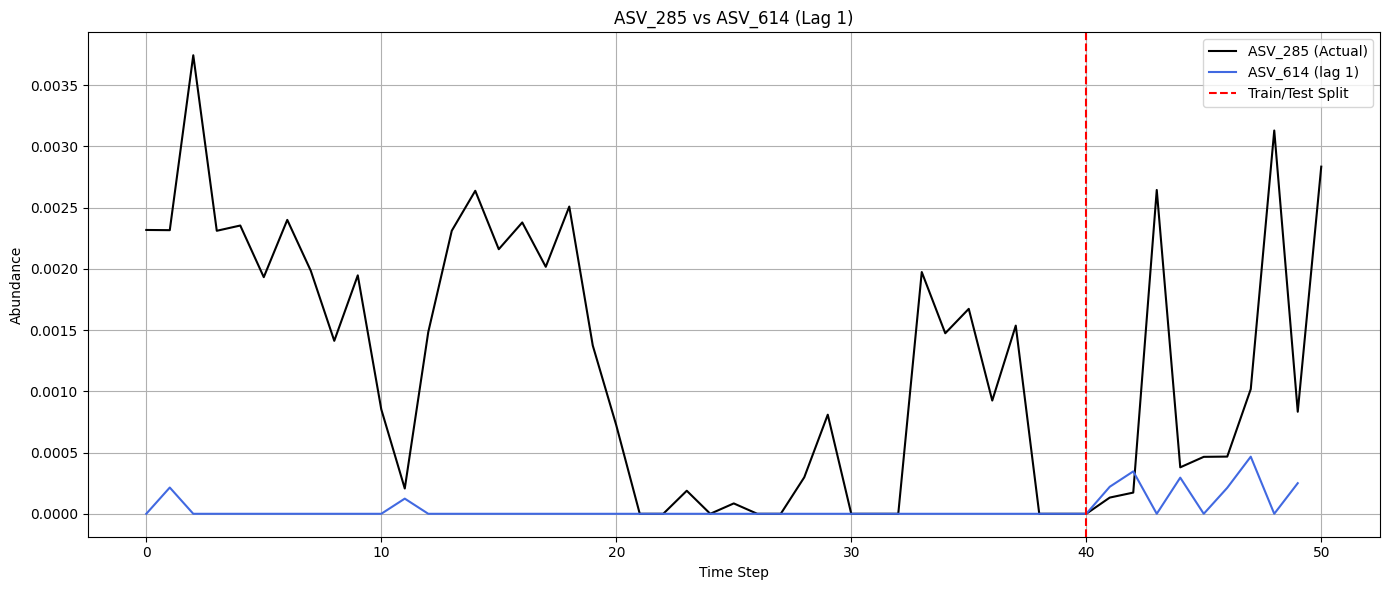

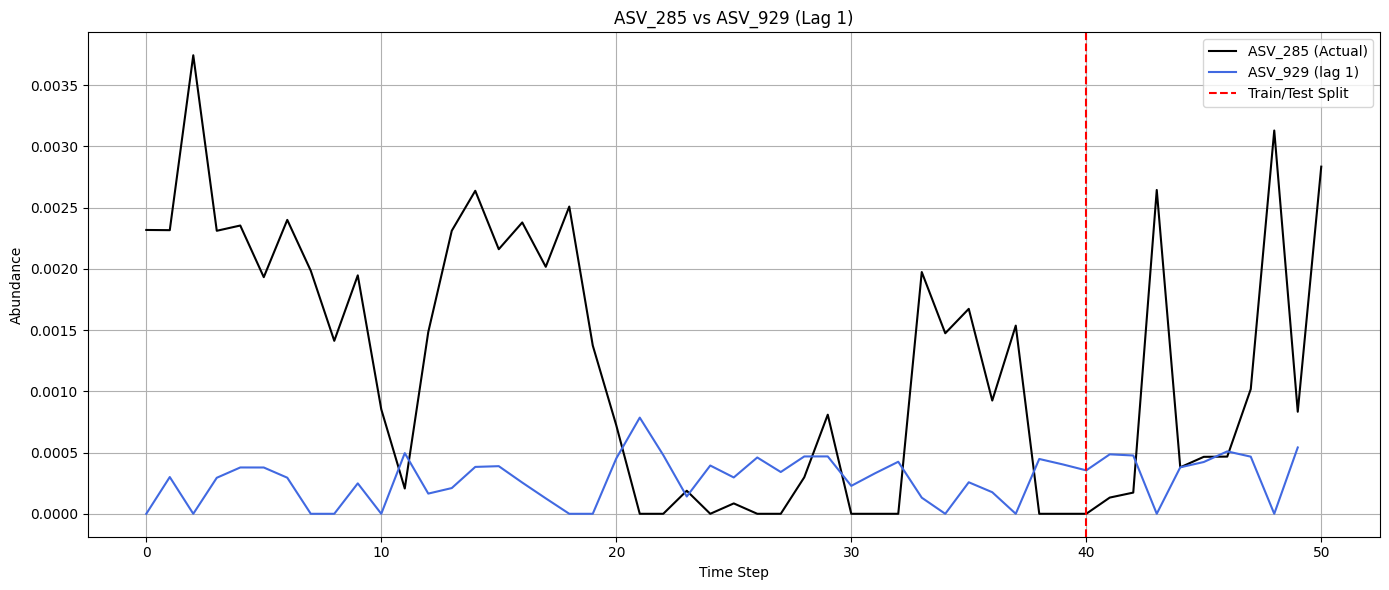

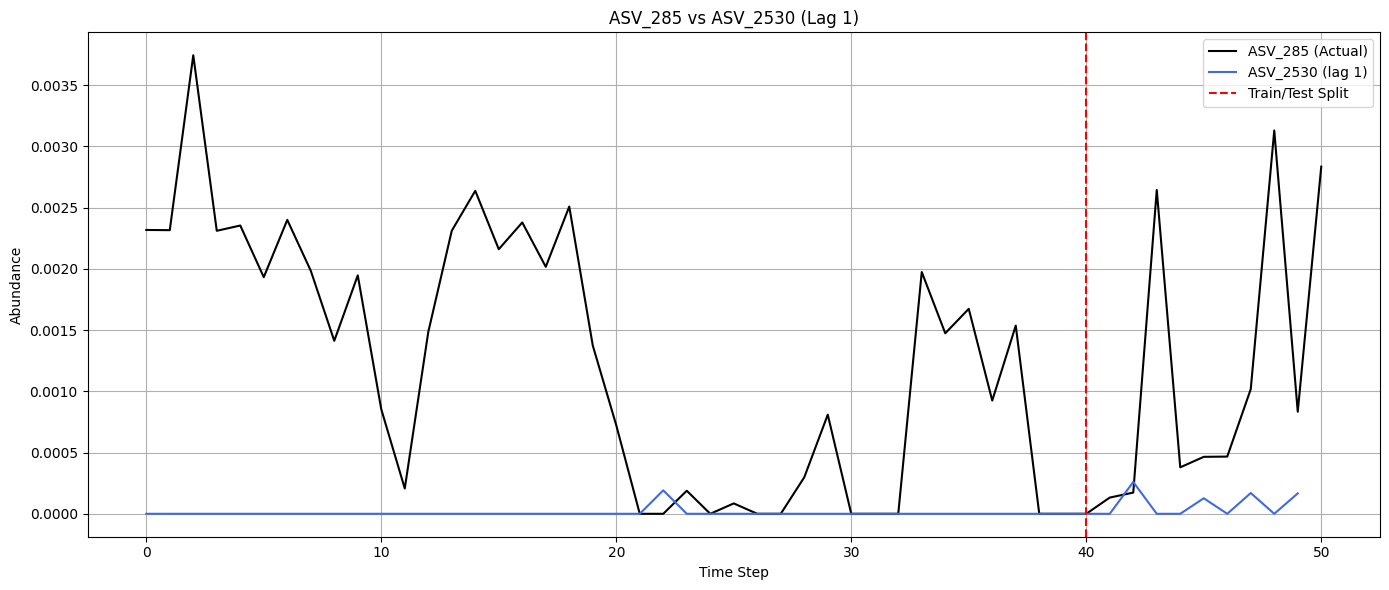

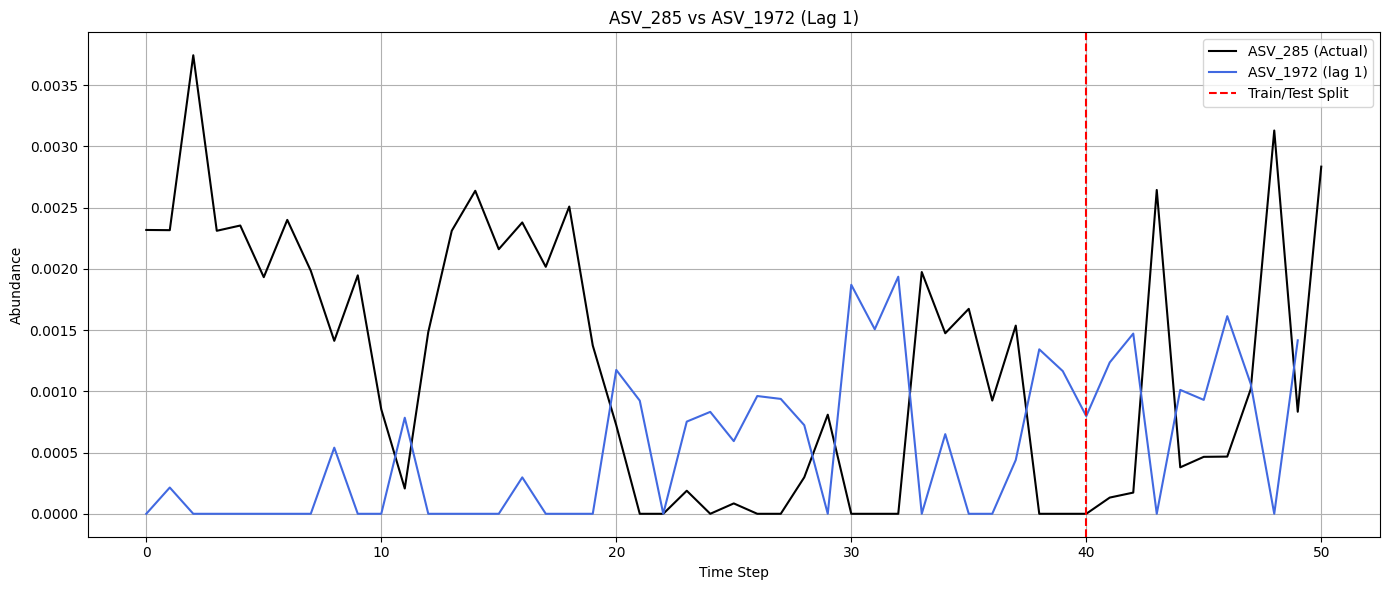

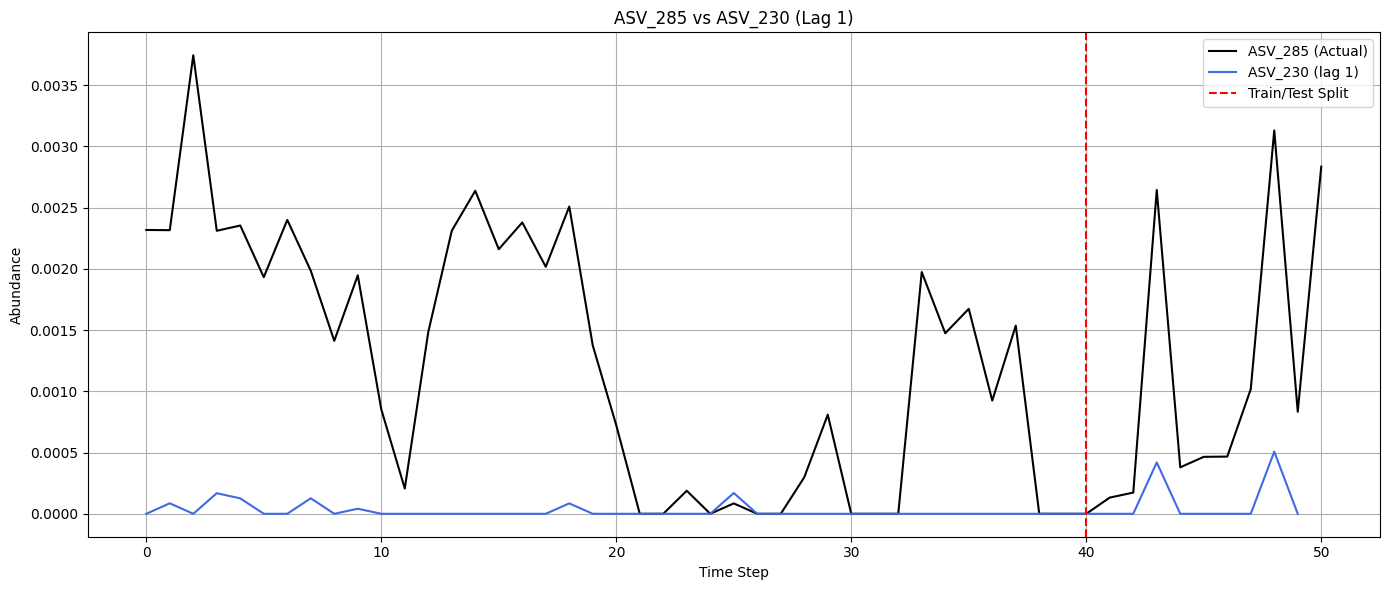

In [196]:
# lagged_correlations['lag_1']는 앞에서 만든 시리즈
top_lagged_asvs = lagged_correlations['lag_1'].head(5).index.tolist()
lag = 1  # 사용할 시차

# 기준 시계열
Y_actual = uk_df['ASV_285']
# Y_actual = Y_actual.iloc[lag:].reset_index(drop=True)

# 반복해서 시각화 (양식 고정)
for asv in top_lagged_asvs:
    Y_lagged = uk_df[asv].shift(lag).iloc[lag:].reset_index(drop=True)
    
    plt.figure(figsize=(14, 6))
    plt.plot(Y_actual.values, label='ASV_285 (Actual)', color='black', linestyle='-')
    plt.plot(Y_lagged.values, label=f'{asv} (lag {lag})', color='royalblue')
    plt.axvline(int(len(Y_actual) * 0.8), color='red', linestyle='--', label='Train/Test Split')
    plt.title(f'ASV_285 vs {asv} (Lag {lag})')
    plt.xlabel('Time Step')
    plt.ylabel('Abundance')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [175]:
X

,ASV_614,ASV_929,ASV_2530,ASV_1972,ASV_230,ΔASV_285_t-1
UK03A,0.000214,3.001844e-04,0.000000,0.000214,0.000086,-0.000002
UK04A,-0.000214,-3.001844e-04,0.000000,-0.000214,-0.000086,0.001428
UK05A,0.000000,2.940806e-04,0.000000,0.000000,0.000168,-0.001433
UK06A,0.000000,8.418194e-05,0.000000,0.000000,-0.000042,0.000043
UK08A,0.000000,-2.700740e-07,0.000000,0.000000,-0.000126,-0.000422
UK09A,0.000000,-8.330523e-05,0.000000,0.000000,0.000000,0.000468
UK10A,0.000000,-2.946872e-04,0.000000,0.000000,0.000127,-0.000415
UK11A,0.000000,0.000000e+00,0.000000,0.000540,-0.000127,-0.000572
UK12A,0.000000,2.485295e-04,0.000000,-0.000540,0.000041,0.000535
UK13A,0.000000,-2.485295e-04,0.000000,0.000000,-0.000041,-0.001094


In [176]:
y

UK03A    0.001428
UK04A   -0.001433
UK05A    0.000043
UK06A   -0.000422
UK08A    0.000468
UK09A   -0.000415
UK10A   -0.000572
UK11A    0.000535
UK12A   -0.001094
UK13A   -0.000647
UK14A    0.001278
UK15A    0.000827
UK16A    0.000326
UK17A   -0.000477
UK18A    0.000218
UK19A   -0.000362
UK20A    0.000492
UK21A   -0.001134
UK22A   -0.000651
UK23A   -0.000723
UK24A    0.000000
UK25A    0.000188
UK26A   -0.000188
UK27A    0.000085
UK28A   -0.000085
UK29A    0.000000
UK30A    0.000298
UK31A    0.000511
UK32A   -0.000809
UK33A    0.000000
UK34A    0.000000
UK35A    0.001974
UK36A   -0.000500
UK37A    0.000199
UK38A   -0.000749
UK39A    0.000612
UK40A   -0.001537
UK41A    0.000000
UK42A    0.000000
UK43A    0.000132
UK44A    0.000041
UK45A    0.002471
UK46A   -0.002264
UK47A    0.000086
UK48A    0.000002
UK49A    0.000551
UK50A    0.002112
UK51A   -0.002296
UK52A    0.002001
Name: ASV_285, dtype: float64

In [184]:
uk_df

,Actual Inf rate (m3/d),℃ Temp.Max.SamplingDate,℃ Temp.Avg.SamplingDate,℃ Temp.Min.SamplingDate,℃ Dew.Max.SamplingDate,℃ Dew.Avg.SamplingDate,℃ Dew.Min.SamplingDate,℃ Humidity.Max.SamplingDate,℃ Humidity.Min.SamplingDate,℃ Wind.Max.SamplingDate,...,ASV_2849,ASV_2850,ASV_2851,ASV_2852,ASV_2853,ASV_2854,ASV_2855,ASV_2856,ASV_2857,ASV_2858
UK01A,17254.0,6.67,3.33,0.56,36,32,30,93,70,25,...,0.000000,0.000000,0.000000,0.000145,0.000724,0.000000,0.000000,0.000000,0.000000,0.000000
UK02A,7007.0,5.56,3.33,0.56,34,31,27,81,65,13,...,0.000343,0.000343,0.000129,0.000129,0.000000,0.000214,0.000000,0.000000,0.000000,0.000000
UK03A,7197.0,5.56,4.44,2.78,37,35,34,87,76,9,...,0.000128,0.000425,0.000000,0.000085,0.000000,0.000766,0.000000,0.000000,0.000000,0.000000
UK04A,6126.0,11.67,10.00,8.89,46,45,45,87,76,26,...,0.000000,0.000588,0.000294,0.000252,0.000000,0.001470,0.000000,0.000126,0.000000,0.000000
UK05A,6898.0,10.56,7.78,5.56,50,45,41,94,82,20,...,0.000294,0.000000,0.000294,0.000420,0.000000,0.000294,0.000000,0.000000,0.000000,0.000000
UK06A,6049.0,8.89,5.56,2.78,36,34,30,81,50,18,...,0.000084,0.000294,0.000252,0.000504,0.000000,0.000000,0.000000,0.000210,0.000000,0.000000
UK08A,4752.0,11.67,5.56,0.00,39,36,30,100,44,9,...,0.000253,0.000000,0.000168,0.000421,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
UK09A,6982.0,8.89,4.44,0.56,36,32,28,87,46,24,...,0.000296,0.000507,0.000296,0.001013,0.000000,0.000000,0.000000,0.000211,0.000000,0.000000
UK10A,6860.0,7.78,5.56,2.78,39,37,34,87,71,18,...,0.000000,0.000581,0.000000,0.000166,0.000000,0.000000,0.000000,0.000291,0.000000,0.000000
UK11A,6159.0,15.00,9.44,3.89,45,42,36,93,55,14,...,0.000166,0.000456,0.000124,0.000497,0.000000,0.000331,0.000000,0.000456,0.000000,0.000000


In [195]:
top_asvs

['ASV_614', 'ASV_929', 'ASV_2530', 'ASV_1972', 'ASV_230']

In [ ]:
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 1. diff 데이터 생성
# diff_df = uk_df.diff()
asv_columns = [col for col in uk_df.columns if col.startswith('ASV_')]

# 상관계수 행렬 계산
y_diff = uk_df[asv_columns].diff().dropna()


# 2. 입력 feature: lag=1에서 상위 5개 ASV
top_asvs = lagged_correlations['lag_1'].head(5).index.tolist()
feature_list= ['℃ Temp.Max.SamplingDate',
 '℃ Temp.Avg.SamplingDate',
 '℃ Temp.Min.SamplingDate',
 '℃ Dew.Max.SamplingDate',
 '℃ Dew.Avg.SamplingDate',
 '℃ Dew.Min.SamplingDate',
 '℃ Temp.Max.WeekMean',
 '℃ Temp.Avg.WeekMean',
 '℃ Temp.Min.WeekMean',
 '℃ Dew.Max.WeekMean',
 '℃ Dew.Avg.WeekMean',
 '℃ Dew.Min.WeekMean',
 '℃ Temp.Max.WeekMax',
 '℃ Temp.Avg.WeekMax',
 '℃ Temp.Min.WeekMax',
 '℃ Dew.Max.WeekMax',
 '℃ Dew.Avg.WeekMax',
 '℃ Dew.Min.WeekMax',
 '℃ Humidity.Max.WeekMax',
 'Total Phosphorus (mg/L) In',
 'Total Phosphorus (mg/L) Out',
 'Temp (oC) AS']

# 3. 입력 X: 상위 ASV들의 t-1 시점 값
X = uk_df[top_asvs].shift(1)
X['ASV_285_t-1'] = uk_df['ASV_285'].shift(1)
X


,ASV_614,ASV_929,ASV_2530,ASV_1972,ASV_230,ASV_285_t-1
UK01A,NaN,NaN,NaN,NaN,NaN,NaN
UK02A,0.000000,0.000000,0.000000,0.000000,0.000000,0.002317
UK03A,0.000214,0.000300,0.000000,0.000214,0.000086,0.002316
UK04A,0.000000,0.000000,0.000000,0.000000,0.000000,0.003744
UK05A,0.000000,0.000294,0.000000,0.000000,0.000168,0.002311
UK06A,0.000000,0.000378,0.000000,0.000000,0.000126,0.002354
UK08A,0.000000,0.000378,0.000000,0.000000,0.000000,0.001932
UK09A,0.000000,0.000295,0.000000,0.000000,0.000000,0.002400
UK10A,0.000000,0.000000,0.000000,0.000000,0.000127,0.001985
UK11A,0.000000,0.000000,0.000000,0.000540,0.000000,0.001412


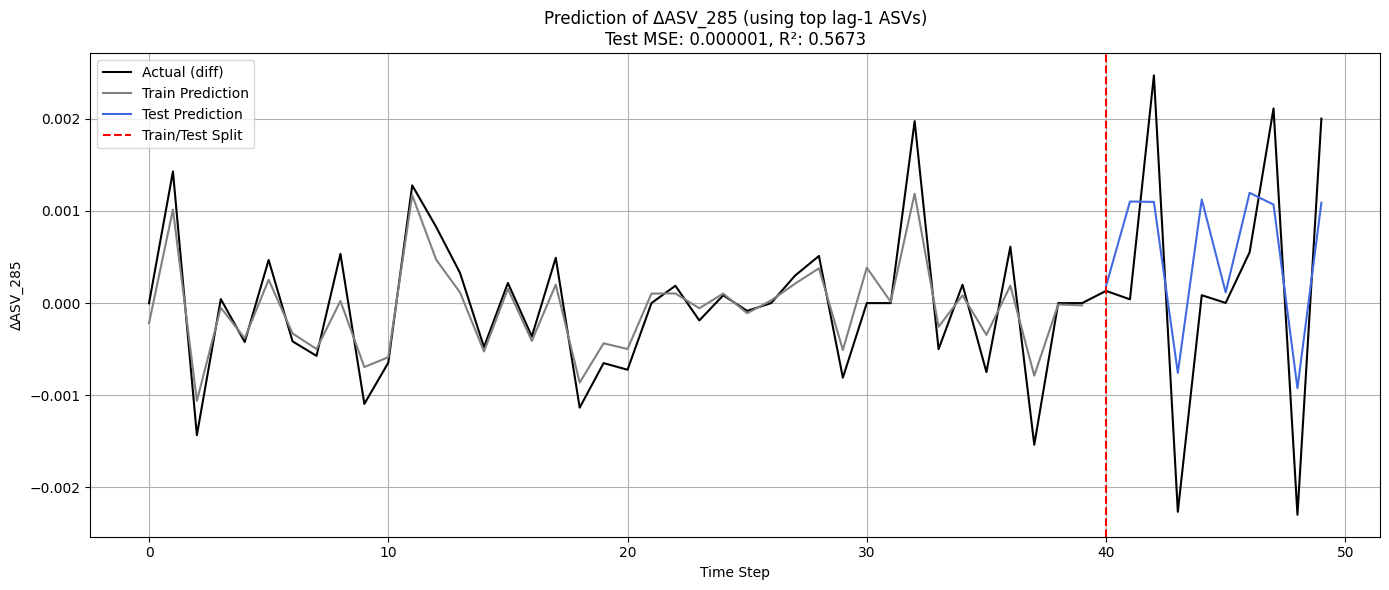

In [192]:

# X = diff_df[top_asvs].shift(1)
# X['ΔASV_285_t-1'] = diff_df['ASV_285'].shift(1)

# 4. 타겟 Y: ASV_285의 변화량
y = diff_df['ASV_285']

# 5. 결측치 제거 (shift, diff로 인해 생긴 NA 제거)
valid_idx = X.notna().all(axis=1) & y.notna()
X = X[valid_idx]
y = y[valid_idx]

# 6. train/test split
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# 7. 모델 학습
# model = XGBRegressor(objective='reg:squarederror', random_state=1004)
# model.fit(X_train, y_train)

model = RandomForestRegressor(n_estimators=100, random_state=1004)
model.fit(X_train, y_train)

# 8. 예측
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
y_actual = pd.concat([y_train, y_test], ignore_index=True)

# 9. 성능 지표
mse = mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

# 10. 시각화 (고정 양식)
plt.figure(figsize=(14, 6))
plt.plot(y_actual.values, label='Actual (diff)', color='black', linestyle='-')
plt.plot(range(split_idx), y_train_pred, label='Train Prediction', color='gray')
plt.plot(range(split_idx, len(y_actual)), y_test_pred, label='Test Prediction', color='royalblue')
plt.axvline(split_idx, color='red', linestyle='--', label='Train/Test Split')
plt.title(f'Prediction of ΔASV_285 (using top lag-1 ASVs)\nTest MSE: {mse:.6f}, R²: {r2:.4f}')
plt.xlabel('Time Step')
plt.ylabel('ΔASV_285')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
